# waste sorter

(based on https://github.com/fastai/fastbook/blob/master/02_production.ipynb)

Let's try to train a model that is able to sort waste following the recommendations of the city of Strasbourg, France:

![./waste_sorting_strasbourg.png](./waste_sorting_strasbourg.png)

We can see heere that we have 3 main categories of waste to sort in different bins:

- **Green**: glass
- **Yellow**: all plastic, metal, and cardboard packagings
- **Blue**: everything else

We are going to search for images on the internet, and then train a model to sort them. The main challenge here will be to grab suitable data, especially for the blue bin: we need blue bin items that do no overlap with the other bins. How to make the correct search queries to get the right blue bin images without overfitting ourselves or the model? We will try to make subcategories for each bin and then reference their green/yellow/blue bins as the y labels.

If you look for "litter" over the Internet, chances are you are going to end up with photos of pile of unsorted waste, which is not very practical for our purpose... So finding the right data will be paramount for success.

In [ ]:
!pip install -U fastai duckduckgo_search ipywidgets

In [1]:
from duckduckgo_search import ddg_images
from fastai.vision.all import *
from fastai.vision.utils import *
from fastai.vision.widgets import *
from fastcore.all import *
from fastdownload import download_url
from pathlib import Path
from PIL import Image
from time import sleep

## Search for images

In [2]:
# utility function to search for images
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # `itemgot` here will return a list of only the objects under a given key
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Searching for 'glass bottle waste'


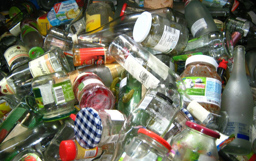

In [6]:
# let's find some suitable key terms that are common representatives of our litter categories
# let's start with green bin waste
download_url(search_images('glass bottle waste', max_images=1)[0], 'example_green_waste.jpg', show_progress=False)
sleep(1)
Image.open('example_green_waste.jpg').to_thumb(256,256)

Searching for 'plastic bottle'


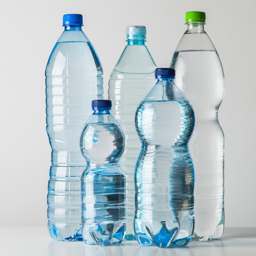

In [7]:
# we go one with yellow bin waste
download_url(search_images('plastic bottle', max_images=1)[0], 'example_yellow_waste.jpg', show_progress=False)
Image.open('example_yellow_waste.jpg').to_thumb(256,256)

Searching for 'food scraps'


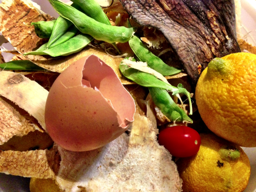

In [8]:
# and now blue bin waste
download_url(search_images('food scraps', max_images=1)[0], 'example_blue_waste.jpg', show_progress=False)
Image.open('example_blue_waste.jpg').to_thumb(256,256)

In [9]:
# now let's build subcategories for each of our three main categories
# we'll try to reference every item that is listed in the Strasbourg informative sheet;
# rapid human checks for the web searches relevancy have been made for each item,
# I just asked myself the question "would I throw this in the bin I'm looking for?"
# I tried here to have the same length for each list, but the official list is not balanced, this was a pain point,
# so I had to add the search querieshous that are the more general for each category
bins = {
    'yellow': ['household product bottle', 'plastic packaging', 'metal packaging', 'paper scraps', 'cardboard packaging scraps'],
    'green': ['glass bottle waste', 'glass flask', 'glass beer scraps', 'wine bottle', 'glass packaging'],
    'blue': ['food scraps', 'trash bags', 'dinner scraps', 'broken dish', 'household waste bag']
}

In [ ]:
# let's search for images of litter items, we're downloading a maximum of 30 images per item
# this gives us a total of 5 * 30 * 3 = 450 images to train on
path = Path('green_yellow_blue')

# ! uncomment if you have an empty dataset or want to download more images (try to tweak the search terms first)
# for bin, items in bins.items():
#     for item in items:
#         dest = (path/bin.replace(' ', '_'))
#         dest.mkdir(exist_ok=True, parents=True)
#         download_images(dest, urls=search_images(f'{item}'))
#         sleep(10)  # Pause between searches to avoid over-loading server
#         resize_images(path/bin.replace(' ', '_'), max_size=224, dest=path/bin.replace(' ', '_'))

In [57]:
# getting rid of corrupted or bad images
for bin, items in bins.items():
    failed = verify_images(get_image_files(Path(path/bin.replace(' ', '_'))))
    failed.map(Path.unlink)
    for img in Path(path/bin.replace(' ', '_')).glob("*!d"):
        img.unlink()
    for img in Path(path/bin.replace(' ', '_')).glob("*gif"):
        img.unlink()
    for img in Path(path/bin.replace(' ', '_')).glob("*Zone.Identifier"):
        img.unlink()
    len(failed)

## creating our dataset for training

In [89]:
# creating our data loader, which will make the data available for our trainer as `train` and `valid` sets;
# a data loader always needs:
    # the type of data you're working with
    # how to get the list of items
    # how to label these items
    # how to split the data into a training and validation set
dls = DataBlock(
    # 1st parameter: what kind of input/output do we have ?
    blocks=(ImageBlock, CategoryBlock),
    # 2nd parameter: what things are we going to train from ?
    get_items=get_image_files,
    # 3rd parameter: what data do we set aside to test the accuracy of our model ? 
        # (we put a fixed seed here so that we always get the same validation set while developing our model)
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # 4th parameter: how do we know the correct label for each image ?
        # (we use the name of the folder the image is in)
    get_y=parent_label,
    # 5th parameter: how do we make all the input images the same size ?
        # we could also have used `RandomResizedCrop` as in `Resize(192, method='squish')`,
        # or some other tansforms
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)],
    # 6th parameter: how do we distort the images to make our model more robust ?
    # here we make them super big
    batch_tfms=aug_transforms(mult=2)
).dataloaders(path/"green_yellow_blue", bs=16)

Let's dwell on this piece of code =>

```python
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms(mult=2)
).dataloaders(path, bs=16)
```
`blocks=(ImageBlock, CategoryBlock)` specifies which variables are _dependent_ or _independent_. Here, we have images as independent variables, and categories as dependent variables. An independent variable is the thing we are using to make predictions from, and the dependent variable is our target. In this case, we are trying to predict the category of the waste from the image.

`get_y=parent_label` is a function that returns the parent directory of the image. In our case, the parent directory is the category of the waste. The independent variable is often referred to as _x_ and the dependent variable is often referred to as _y_. 

`item_tfms=[RandomResizedCrop(224, min_scale=0.5)]` is a transformation that randomly selects a part of the image, and crops it to just that part. It's also better for a model to work with images of the same size. This is better than just stretching, cropping, or squishing the images because these transforms affect the realistic appearance of the image.
Random resize cropping works by randomly selecting bits of a given image across each epoch. This helps the model recognize different distinctive features of the image.

`batch_tfms=aug_transforms(mult=2)` applies data augmentation techniques that will create slight variations of our data. Common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. It's okay to apply the transformations to these images using the GPU since they all have the same size. Using the GPU saves us a lot of time.


In [90]:
# in case you forgot the vocabulary of your model
# also checking if the path we used is correct
dls.vocab, Path(path/"green_yellow_blue").ls()

(['blue', 'green', 'yellow'],
 (#3) [Path('green_yellow_blue/blue'),Path('green_yellow_blue/yellow'),Path('green_yellow_blue/green')])

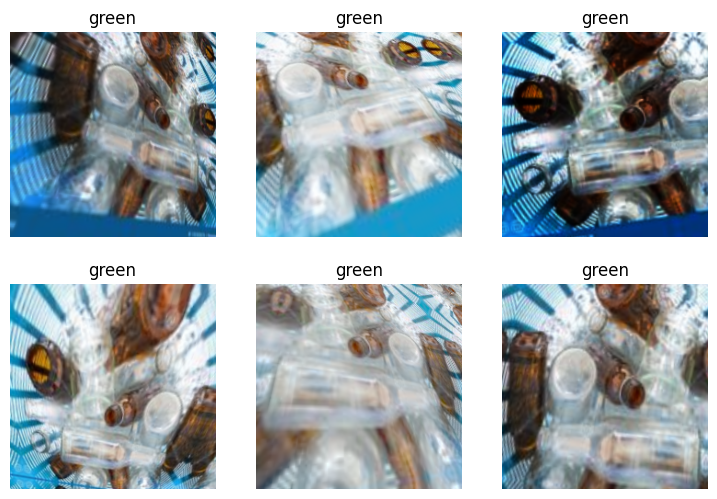

In [91]:
# this says "show me a batch of data that you are passing to the model"
# it will automatically show you useful data
dls.show_batch(max_n=6, unique=True)

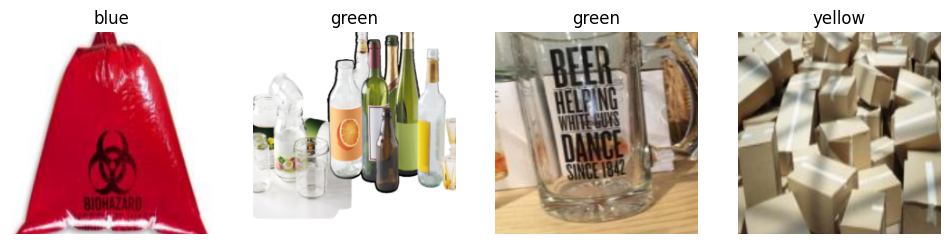

In [92]:
# let's see what we got in our data block
dls.valid.show_batch(max_n=4, nrows=1)

## actually train the thing

We are going to train our model before actually training the data, we are going to see why it's cool in a minute.

In [98]:
# the `resnet` number denotes the depth of the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.626784,0.422680,0.172840,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.687683,0.267735,0.086420,00:02
1,0.591902,0.275446,0.074074,00:02
2,0.494064,0.193697,0.049383,00:02
3,0.440310,0.218857,0.074074,00:02


  - the training loss measures how well the model is **fitting** the training data
  - the validation loss measures how well the model is generalizes to new data

## interpret the results and clean the data

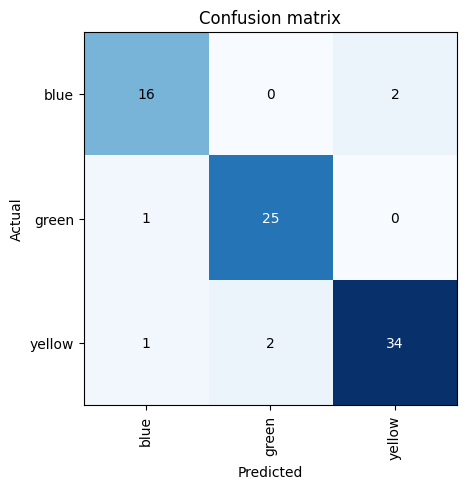

In [99]:
# how confused is our model at this stage ?
# the diagonal will show what was correctly classified and the off-diagonal squares will show what was misclassified
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The above tells us, for instance, that our model mistook a picture of a glass bottle for a plastic bottle 5 times; we can say here that most errors happen in the yellow category.

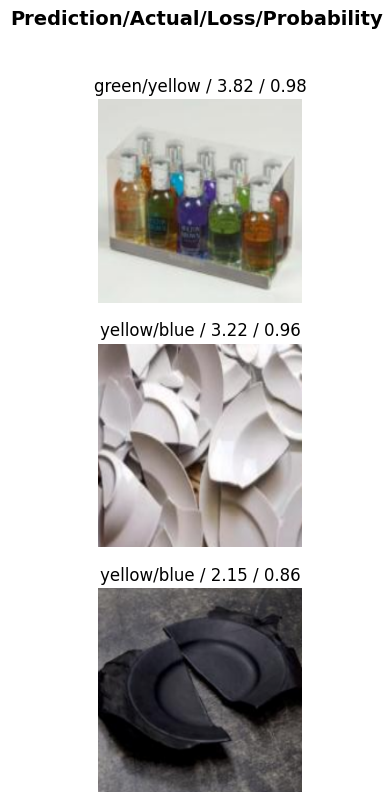

In [101]:
# sorting images by loss can be helpful to spot datasets problems
# loss can be high when the model is highly confident but wrong or when the model is not confident at all but right
# output will be (from left to right): predicted label, actual label, loss, probability (in other words, confidence level) of the predicted label
interp.plot_top_losses(3, nrows=3)

In [102]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [40]:
for idx in cleaner.delete(): print(cleaner.fns[idx])
# now we know which images to delete, the classifier is quite buggy on my machine so I had to delete them manually, but you get the idea
# ! stay in the domain when re fining your data
# once you've deleted the images, redo all the relevant steps (without the web search of course) 
# you should get a better model after a few iterations of this process, don't hesitate to manually download new relevant images

# the cleaner will return a list of indices of images
# example of how you would delete images scheduled for deletion `for idx in cleaner.delete(): cleaner.fns[idx].unlink()`
# example of how you would move images which categories have changed `for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)`

# You now know how to use a model for data preparation, and how to clean your data ;) remember, it's an iterative process !

## exporting the model

In [103]:
# package up our model and export it
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [104]:
# loading the exported inference learner
learn_inf = load_learner(path/'export.pkl')

In [105]:
# testing it
learn_inf.predict('example_yellow_waste.jpg')

# now you can use this function as any other function in python ! pretty cool huh ?

('yellow', tensor(2), tensor([0.2514, 0.0200, 0.7285]))

This shows something like `('bottle_glass', tensor(0), tensor([9.9528e-01, 4.0391e-03, 6.8570e-04]))`, this represents, from left to right:
    - the predicted class
    - the index of the predicted class
    - the probabilities of each class

## prototyping an application

In [56]:
# now all you have to do is serve a file upload button to your users and call this function on the uploaded file
# this will return a practical prediction for the every day life !

def classify_and_output(upload):
    img = PILImage.create(upload)
    pred,pred_idx,probs = learn_inf.predict(img)
    return f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
